In [2]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from collections import deque

import qubx
%qubxd dev

%load_ext autoreload
%autoreload 2

import tests.qubx.ta.utils_for_testing as test
from qubx.utils import set_mpl_theme, fig, sbp

T = pd.date_range('2024-01-01 00:00', freq='1Min', periods=100_000)
ds = 100 + (1 * np.random.randn(len(T))).cumsum()
data = list(zip(T, ds))
# %load_ext cython

 >  [dev] installing cython rebuilding hook
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## <font color='gray'>Reload dev environment</font>

In [3]:
from qubx.core.series import TimeSeries; from qubx.ta.indicators import sma; del sys.modules['qubx.core.series']; del sys.modules['qubx.ta.indicators']
from qubx.core.series import TimeSeries, OHLCV, lag, compare
from qubx.core.utils import recognize_time
from qubx.ta.indicators import (sma, ema, tema, dema, kama, highest, lowest)

## <b>Series tests</b>

In [4]:
# %%timeit
ts = TimeSeries('test', '10Min')
ts.update(recognize_time('2024-01-01 00:00'), 1)
ts.update(recognize_time('2024-01-01 00:01'), 5)
ts.update(recognize_time('2024-01-01 00:06'), 2)
ts.update(recognize_time('2024-01-01 00:12'), 3)
ts.update(recognize_time('2024-01-01 00:21'), 4)
ts.update(recognize_time('2024-01-01 00:22'), 5)
ts.update(recognize_time('2024-01-01 00:31'), 6)
ts.update(recognize_time('2024-01-01 00:33'), 7)
ts.update(recognize_time('2024-01-01 00:45'), -12)
ts.update(recognize_time('2024-01-01 00:55'), 12)
ts.update(recognize_time('2024-01-01 01:00'), 12)

1

In [5]:
ts.to_series()

2024-01-01 00:00:00     2.0
2024-01-01 00:10:00     3.0
2024-01-01 00:20:00     5.0
2024-01-01 00:30:00     7.0
2024-01-01 00:40:00   -12.0
2024-01-01 00:50:00    12.0
2024-01-01 01:00:00    12.0
Name: test, dtype: float64

## <b>Indicators tests</b>

### <b>Updating by new ticks</b>

In [6]:
# %%timeit 
ts = TimeSeries('close', '1h')
s1 = sma(ts, 50)
e1 = ema(ts, 50)
ss1 = sma(s1, 50)
ee1 = ema(e1, 50)
t1 = tema(ts, 50)
k1 = kama(ts, 50)
d1 = dema(ts, 50)
test.push(ts, data)

2024-01-01 00:00:00    104.633131
2024-01-01 01:00:00     97.409920
2024-01-01 02:00:00     78.473957
2024-01-01 03:00:00     96.111775
2024-01-01 04:00:00     94.853269
                          ...    
2024-03-10 06:00:00   -767.823328
2024-03-10 07:00:00   -765.359154
2024-03-10 08:00:00   -773.774594
2024-03-10 09:00:00   -773.192662
2024-03-10 10:00:00   -773.651900
Name: close, Length: 1667, dtype: float64

In [7]:
k1s = k1.to_series().dropna()
ik1 = test.apply_to_frame(test.kama, ts.to_series(), 50).dropna()
sum(ik1 - k1.to_series().dropna()) < 1e-8

True

In [8]:
k1 = kama(ts, 50)
k1s = k1.to_series().dropna()
sum(ik1 - k1.to_series().dropna()) < 1e-8

True

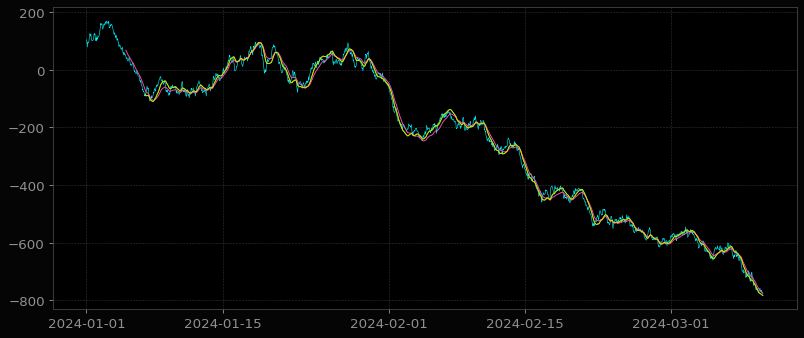

In [9]:
plt.plot(ts.to_series(), lw=0.5)
plt.plot(tema(ts, 50).to_series())
plt.plot(dema(ts, 50).to_series())
plt.plot(t1.to_series())

In [10]:
# %%timeit
x0 = ts.to_series()
pe1 = x0.ewm(span=50, min_periods=50).mean()
pee1 = pe1.ewm(span=50, min_periods=50).mean()
ps1 = x0.rolling(50).mean()
pss1 = ps1.rolling(50).mean()

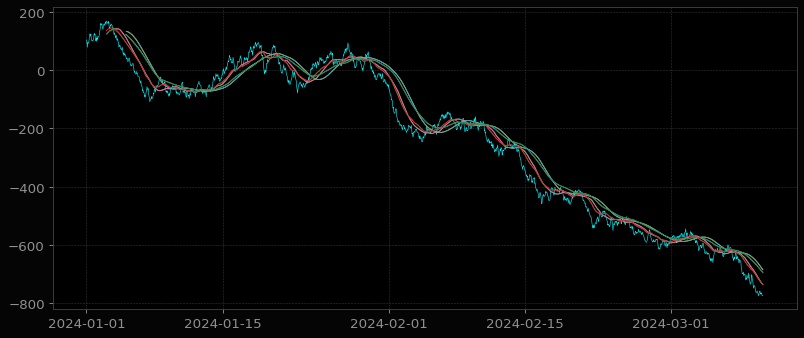

In [11]:
plt.plot(x0, lw=0.5)
plt.plot(s1.to_series()); plt.plot(ps1)
plt.plot(ss1.to_series()); plt.plot(pss1)
plt.plot(e1.to_series()); plt.plot(pe1)
plt.plot(ee1.to_series()); plt.plot(pee1)
# plt.plot(s1.to_series()-ps1)

In [12]:
# %%timeit
s1 = sma(ts, 50)
e1 = ema(ts, 50)
ss1 = sma(s1, 50)
ee1 = ema(e1, 50)
k1 = kama(e1, 50)

In [ ]:
ts.get_indicators()

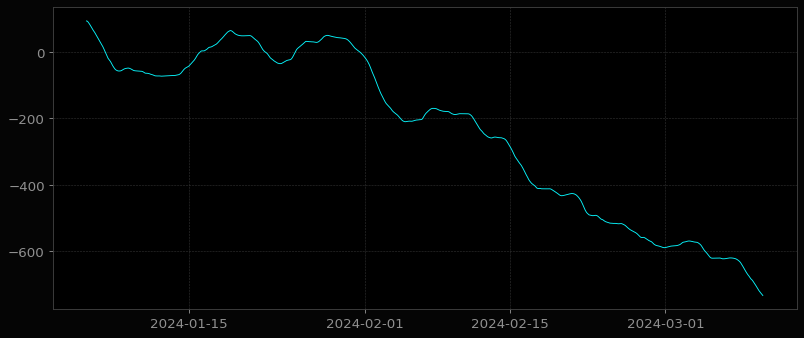

In [13]:
plt.plot(k1.to_series())

### <b>Combining indicators</b>

In [14]:
ts0 = TimeSeries('close', '1Min')
# em0 = sma(ts0, 3)
# em1 = sma(em0, 3)
k0 = kama(ts0, 6)  
l1 = lag(ts0, 1)
l2 = lag(l1, 1)

for t, v in [
    ('2024-01-01 00:00', 9), ('2024-01-01 00:00', 1),
    ('2024-01-01 00:01', 2), ('2024-01-01 00:01', 3),   ('2024-01-01 00:01', 2),
    ('2024-01-01 00:02', 3),
    ('2024-01-01 00:03', 4),
    ('2024-01-01 00:04', 5), ('2024-01-01 00:04', 5.1), ('2024-01-01 00:04:20', 5),
    ('2024-01-01 00:05', 6), ('2024-01-01 00:05', 7),   ('2024-01-01 00:05', 6),
    ('2024-01-01 00:07', 8), ('2024-01-01 00:07', -1),  ('2024-01-01 00:07', 8),
    ('2024-01-01 00:08', 8),
    ('2024-01-01 00:09', 8),
    ('2024-01-01 00:10', 12),
    ('2024-01-01 00:11', 13),
    ('2024-01-01 00:12', 14),
    ('2024-01-01 00:13', 15),
    ('2024-01-01 00:14', 17),
    ('2024-01-01 00:15', 4),
]:
    ts0.update(recognize_time(t), v)
    # print(l3[0])

In [15]:
test.scols(ts0.pd(), l1.pd(), l2.pd())

,close,lag(1),lag(1)
2024-01-01 00:00:00,1.0,NaN,NaN
2024-01-01 00:01:00,2.0,1.0,NaN
2024-01-01 00:02:00,3.0,2.0,1.0
2024-01-01 00:03:00,4.0,3.0,2.0
2024-01-01 00:04:00,5.0,4.0,3.0
2024-01-01 00:05:00,6.0,5.0,4.0
2024-01-01 00:07:00,8.0,6.0,5.0
2024-01-01 00:08:00,8.0,8.0,6.0
2024-01-01 00:09:00,8.0,8.0,8.0
2024-01-01 00:10:00,12.0,8.0,8.0


In [16]:
lag(ts0, 2).to_series() == l2.to_series()

2024-01-01 00:00:00    False
2024-01-01 00:01:00    False
2024-01-01 00:02:00     True
2024-01-01 00:03:00     True
2024-01-01 00:04:00     True
2024-01-01 00:05:00     True
2024-01-01 00:07:00     True
2024-01-01 00:08:00     True
2024-01-01 00:09:00     True
2024-01-01 00:10:00     True
2024-01-01 00:11:00     True
2024-01-01 00:12:00     True
2024-01-01 00:13:00     True
2024-01-01 00:14:00     True
2024-01-01 00:15:00     True
dtype: bool

In [ ]:
ts0.get_indicators()

In [20]:
ll2 = lag(lag(ts0, 1),1)

### <font color='orange'><b>Cached indicators</b></font>

In [17]:
ts = TimeSeries('close', '2Min')
m = (sma(ts, 3) - 1000) / (sma(ts, 3) * 1000)
test.push(ts, data[:20]);

In [18]:
m

2024-01-01 00:00:00         NaN
2024-01-01 00:02:00         NaN
2024-01-01 00:04:00         NaN
2024-01-01 00:06:00   -0.008796
2024-01-01 00:08:00   -0.008691
2024-01-01 00:10:00   -0.008594
2024-01-01 00:12:00   -0.008527
2024-01-01 00:14:00   -0.008542
2024-01-01 00:16:00   -0.008601
2024-01-01 00:18:00   -0.008653
Name: divide(mult(1000)), dtype: float64

#### Composition 1 test

In [19]:
def test_i(ts: TimeSeries):
	ds = ts - ts.shift(1)
	a1 = sma(ds * (ds > 0), 14) 
	a2 = ds 
	return (a1 - a2) / (a1 + ds)

ts = TimeSeries('close', '30Min')
r1 = test_i(ts)
test.push(ts, data[:1000]);

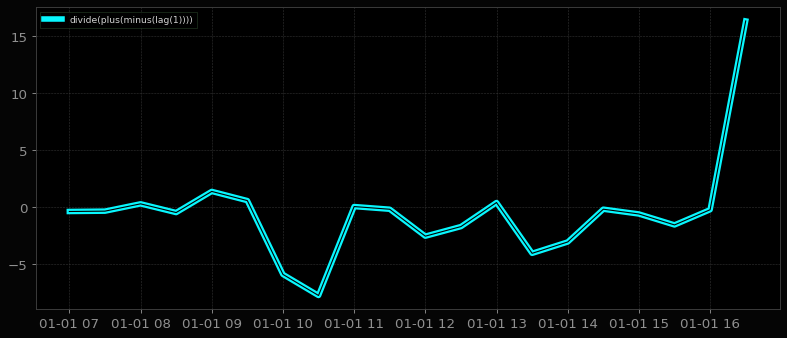

In [20]:
r1 = test_i(ts)
r1.plot(lw=5)

ds = ts.pd().diff()
a1 = test.apply_to_frame(test.sma, ds * (ds > 0), 14)
a2 = ds
plt.plot((a1 - a2) / (a1 + a2), c='k', lw=1)

#### Composition 2 test

In [21]:
T = pd.date_range('2024-01-01 00:00', freq='1Min', periods=100000)
data = list(zip(T, 1000 + (1*np.random.randn(len(T))).cumsum()))

In [22]:
def test_ii(ts: TimeSeries):
	a1 = sma(ts, 5) 
	a2 = sma(ts, 10) * 1000
	return a1 - a2

ts = TimeSeries('close', '10Min')
r11 = test_ii(ts)
test.push(ts, data[:10000]);

In [23]:
r11

2024-01-01 00:00:00              NaN
2024-01-01 00:10:00              NaN
2024-01-01 00:20:00              NaN
2024-01-01 00:30:00              NaN
2024-01-01 00:40:00              NaN
                           ...      
2024-01-07 21:50:00   -826379.907833
2024-01-07 22:00:00   -827814.242046
2024-01-07 22:10:00   -829112.716411
2024-01-07 22:20:00   -830792.621054
2024-01-07 22:30:00   -832222.715765
Name: minus(mult(1000)), Length: 1000, dtype: float64

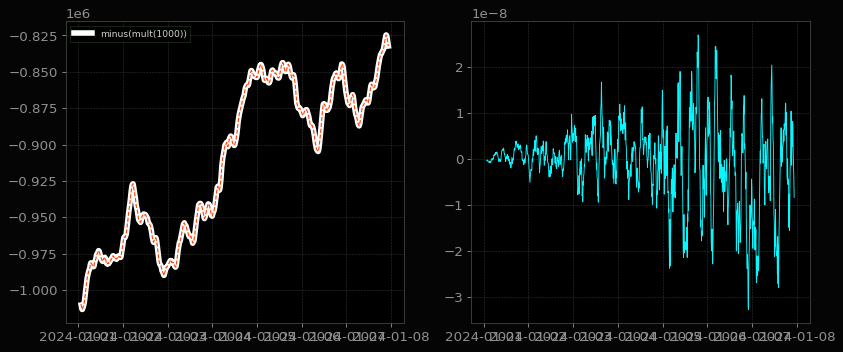

In [24]:
r11 = test_ii(ts)

a1 = test.apply_to_frame(test.sma, ts.pd(), 5)
a2 = 1000*test.apply_to_frame(test.sma, ts.pd(), 10)
sbp(12,1); r11.plot(lw=5, c='w'); plt.plot(xs:=a1 - a2, c='#ff4000', lw=1, ls='--')
sbp(12,2); plt.plot(xs - test_ii(ts).pd());

#### Composition 3 test (<font color='red'>RSI</font>)

In [25]:
def rsi(ts: TimeSeries, period: int):
	ds = ts - ts.shift(1)
	mu = sma(ds * (ds > 0), period)

	# - this doesn't work (FIXED NOW !!!)
	# md = -sma(ds * (ds < 0), period)
	md = sma(abs(ds * (ds < 0)), period)
	return mu / (mu + md)

	# - this works
	# md = sma(ds * (ds < 0), period)
	# return mu / (mu - md)

ts = TimeSeries('close', '2Min')
r1 = rsi(ts, 14)
test.push(ts, data[:100]);

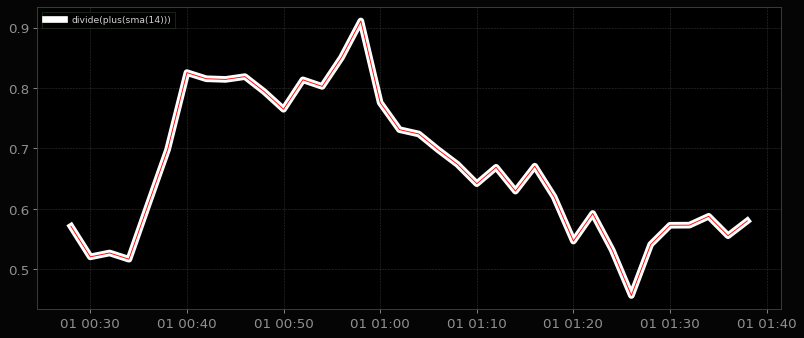

In [26]:
r1 = rsi(ts, 14)
r1.plot(lw=6, c='w')
ds = ts.pd().diff()
mu = test.apply_to_frame(test.sma, ds * (ds > 0), 14)
md = test.apply_to_frame(test.sma, ds * (ds < 0), 14)
plt.plot(mu/(mu - md), c='r')

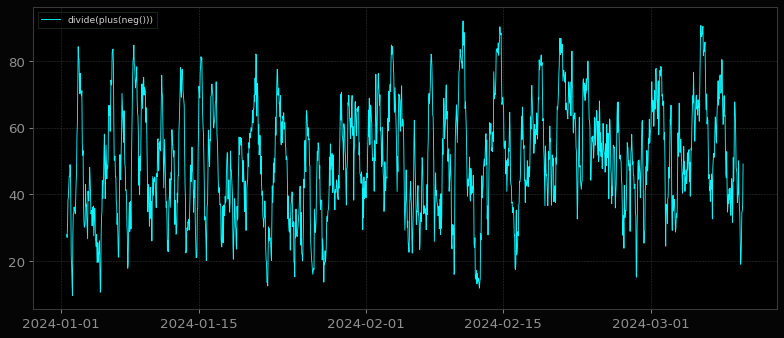

In [27]:
def rsi(ts: TimeSeries, period: int):
	ds = ts - ts.shift(1)
	mu = sma(ds * (ds > 0), period)
	md = -sma(ds * (ds < 0), period)
	return mu * 100 / (mu + md)

ts = TimeSeries('close', '1H')
r1 = rsi(ts, 14)
test.push(ts, data);

r1.plot()

In [29]:
# %%timeit
r1 = rsi(ts, 12)
r2 = rsi(ts, 5)

#### Complex indicators test

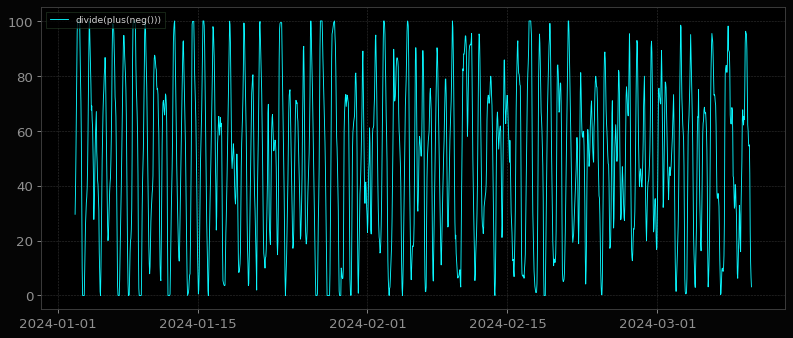

In [30]:
rsi(rsi(sma(ema(r1, 4) - ema(r2, 4), 5), 12), 12).plot()

In [31]:
if 1:
    x = ts.pd()
    xx = pd.concat((x, x.shift(1)), axis=1, keys=['c', 'p'])
    df = (xx.c - xx.p)
    mu2 = test.smooth(df.where(df > 0, 0), test.sma, 12)
    md2 = test.smooth(abs(df.where(df < 0, 0)), test.sma, 12)
    r2 = 100 * mu2 / (mu2 + md2)

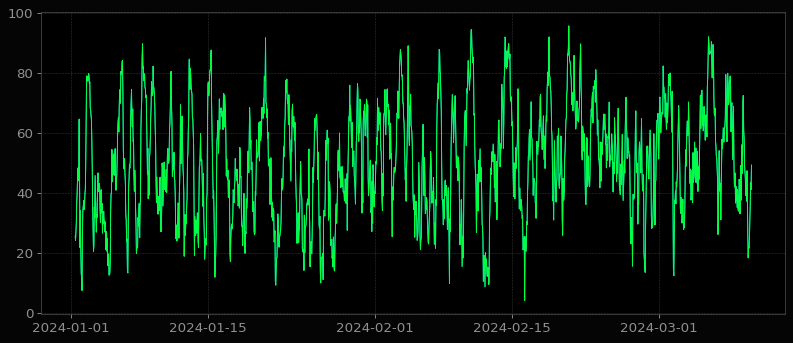

In [32]:
plt.plot(r1.pd())
plt.plot(r2)

In [33]:
# (ts * ((ts - ts.shift(1)) > 0)).plot()
(ts * ((ts - ts.shift(1)) < 0))#.plot()

2024-01-01 00:00:00       0.000000
2024-01-01 01:00:00    1013.933105
2024-01-01 02:00:00    1010.042743
2024-01-01 03:00:00     993.904935
2024-01-01 04:00:00     992.345714
                          ...     
2024-03-10 06:00:00       0.000000
2024-03-10 07:00:00       0.000000
2024-03-10 08:00:00    1126.549875
2024-03-10 09:00:00       0.000000
2024-03-10 10:00:00       0.000000
Name: mult(lessthan(0)), Length: 1667, dtype: float64

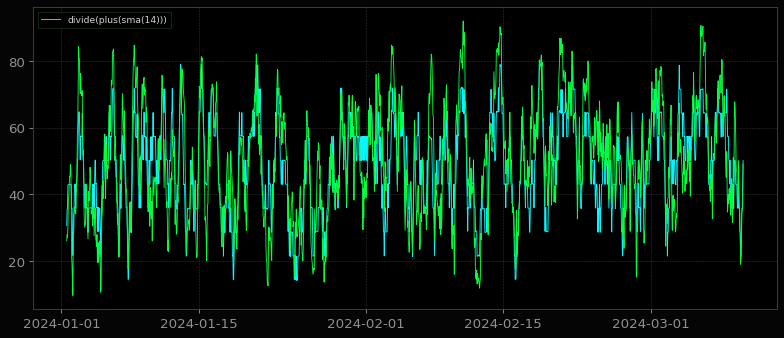

In [34]:
p = 14
rs = sma(ts * ((ts - ts.shift(1)) > 0), p)
ds = sma(ts * ((ts - ts.shift(1)) < 0), p) 
r1 = ((rs * 100) / (rs + ds))
r1.plot()
plt.plot(test.rsi(ts.pd(), p))

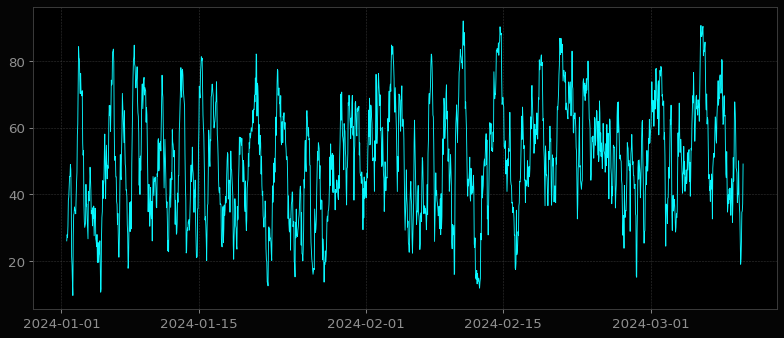

In [35]:
plt.plot(test.rsi(ts.pd(), 14))

In [36]:
def stoch(series, period):
    return (
        (
            (series - lowest(series, period)) / (highest(series, period) - lowest(series, period))
        ) * 100 
    )

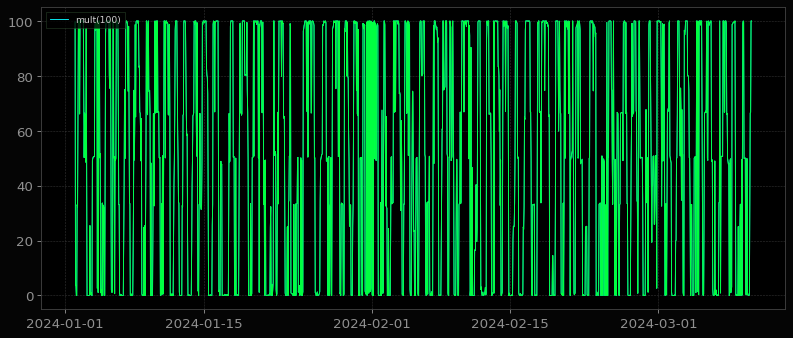

In [37]:
stoch(r1, 12).plot()
plt.plot(test.stochastic(r1.pd(), 12, 1).K)

In [38]:
(stoch(r1, 12).pd() - test.stochastic(r1.pd(), 12, 1).K).mean()

1.0902367934847577e-06

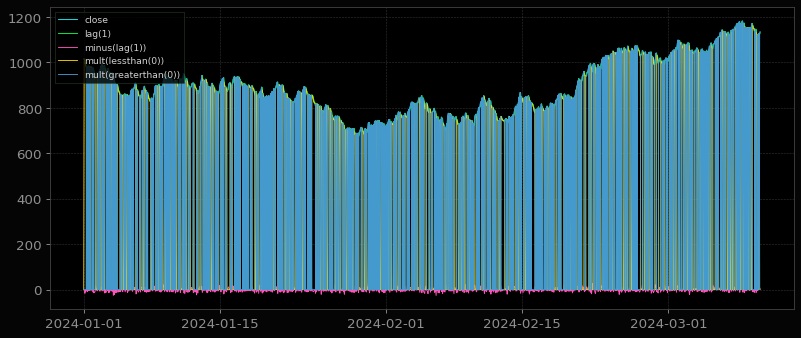

In [39]:
ts.plot(with_indicators=1)

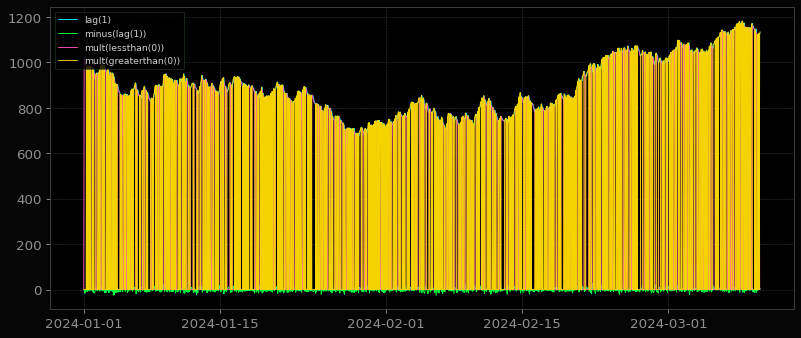

In [40]:
for k, vi in ts.get_indicators().items():
    plt.plot(vi.pd(), label=k)
plt.legend(loc=2)

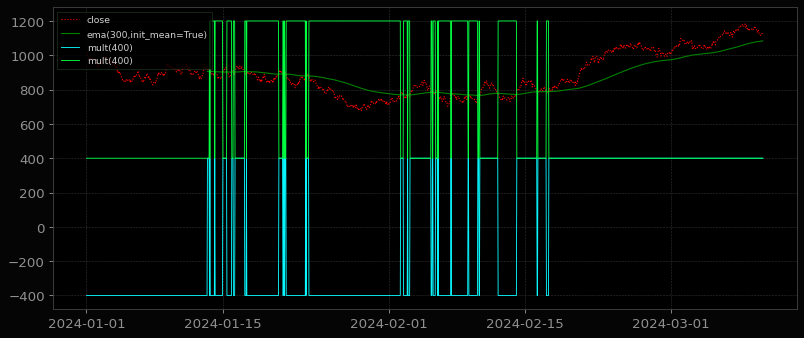

In [41]:
ts.plot(ls=':', lw=1, c='r')
# (ema(ema(ts, 50), 10)).plot(lw=1, c='g')
(ema(ts, 300)).plot(lw=1, c='g')

(((ts > ema(ts, 300))*2 - 1)*400).plot()
(((ts < ema(ts, 300))*2 + 1)*400).plot()

In [42]:
x = sma(ts, 15)

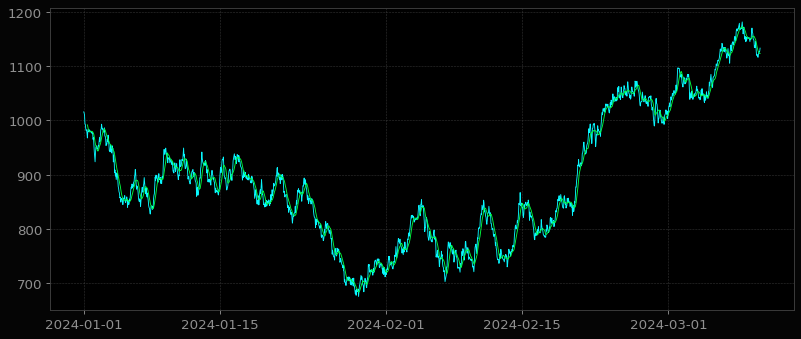

In [43]:
plt.plot(ts.pd())
plt.plot((sma(ts, 10)).pd())

In [44]:
test.scols(ts.pd(), sma(ts, 10).pd())

,close,sma(10)
2024-01-01 00:00:00,1015.790426,NaN
2024-01-01 01:00:00,1013.933105,NaN
2024-01-01 02:00:00,1010.042743,NaN
2024-01-01 03:00:00,993.904935,NaN
2024-01-01 04:00:00,992.345714,NaN
...,...,...
2024-03-10 06:00:00,1121.355038,1127.073248
2024-03-10 07:00:00,1126.807260,1125.934557
2024-03-10 08:00:00,1126.549875,1125.143282
2024-03-10 09:00:00,1127.651104,1123.345620


### <font color='green'><b>OHLC Series tests</b></font>

In [45]:
ohlc = OHLCV('Test1', '1Min')
s1 = sma(ohlc.close, 10)
for t, v in [
    ('2024-01-01 00:00', 9), ('2024-01-01 00:00', 1),
    ('2024-01-01 00:01', 2), ('2024-01-01 00:01', 3),   ('2024-01-01 00:01', 2),
    ('2024-01-01 00:02', 3),
    ('2024-01-01 00:03', 4),
    ('2024-01-01 00:04', 5), ('2024-01-01 00:04', 5.1), ('2024-01-01 00:04:20', 5),
    ('2024-01-01 00:05', 6), ('2024-01-01 00:05', 7),   ('2024-01-01 00:05', 6),
    ('2024-01-01 00:07', 8), ('2024-01-01 00:07', -1),  ('2024-01-01 00:07', 8),
    ('2024-01-01 00:08', 8),
    ('2024-01-01 00:09', 8),
    ('2024-01-01 00:10', 12), ('2024-01-01 00:10:01', 21),('2024-01-01 00:10:30', 1),('2024-01-01 00:10:31', 5),
    ('2024-01-01 00:11', 13),
    ('2024-01-01 00:12', 14),
    ('2024-01-01 00:13', 15),
    ('2024-01-01 00:14', 17),
    ('2024-01-01 00:15', 4), ('2024-01-01 00:15:10', 12),
]:
    ohlc.update(recognize_time(t), v, 1)

In [46]:
ohlc

                     open  high   low  close  volume  bought_volume
timestamp                                                          
2024-01-01 00:00:00   9.0   9.0   1.0    1.0     2.0            0.0
2024-01-01 00:01:00   2.0   3.0   2.0    2.0     3.0            0.0
2024-01-01 00:02:00   3.0   3.0   3.0    3.0     1.0            0.0
2024-01-01 00:03:00   4.0   4.0   4.0    4.0     1.0            0.0
2024-01-01 00:04:00   5.0   5.1   5.0    5.0     3.0            0.0
2024-01-01 00:05:00   6.0   7.0   6.0    6.0     3.0            0.0
2024-01-01 00:07:00   8.0   8.0  -1.0    8.0     3.0            0.0
2024-01-01 00:08:00   8.0   8.0   8.0    8.0     1.0            0.0
2024-01-01 00:09:00   8.0   8.0   8.0    8.0     1.0            0.0
2024-01-01 00:10:00  12.0  21.0   1.0    5.0     4.0            0.0
2024-01-01 00:11:00  13.0  13.0  13.0   13.0     1.0            0.0
2024-01-01 00:12:00  14.0  14.0  14.0   14.0     1.0            0.0
2024-01-01 00:13:00  15.0  15.0  15.0   15.0    

In [47]:
ohlc.close

2024-01-01 00:00:00     1.0
2024-01-01 00:01:00     2.0
2024-01-01 00:02:00     3.0
2024-01-01 00:03:00     4.0
2024-01-01 00:04:00     5.0
2024-01-01 00:05:00     6.0
2024-01-01 00:07:00     8.0
2024-01-01 00:08:00     8.0
2024-01-01 00:09:00     8.0
2024-01-01 00:10:00     5.0
2024-01-01 00:11:00    13.0
2024-01-01 00:12:00    14.0
2024-01-01 00:13:00    15.0
2024-01-01 00:14:00    17.0
2024-01-01 00:15:00    12.0
Name: close, dtype: float64

In [48]:
ohlc[::-1]

[{o:9.000000 | h:9.000000 | l:1.000000 | c:1.000000 | v:2.000000},
 {o:2.000000 | h:3.000000 | l:2.000000 | c:2.000000 | v:3.000000},
 {o:3.000000 | h:3.000000 | l:3.000000 | c:3.000000 | v:1.000000},
 {o:4.000000 | h:4.000000 | l:4.000000 | c:4.000000 | v:1.000000},
 {o:5.000000 | h:5.100000 | l:5.000000 | c:5.000000 | v:3.000000},
 {o:6.000000 | h:7.000000 | l:6.000000 | c:6.000000 | v:3.000000},
 {o:8.000000 | h:8.000000 | l:-1.000000 | c:8.000000 | v:3.000000},
 {o:8.000000 | h:8.000000 | l:8.000000 | c:8.000000 | v:1.000000},
 {o:8.000000 | h:8.000000 | l:8.000000 | c:8.000000 | v:1.000000},
 {o:12.000000 | h:21.000000 | l:1.000000 | c:5.000000 | v:4.000000},
 {o:13.000000 | h:13.000000 | l:13.000000 | c:13.000000 | v:1.000000},
 {o:14.000000 | h:14.000000 | l:14.000000 | c:14.000000 | v:1.000000},
 {o:15.000000 | h:15.000000 | l:15.000000 | c:15.000000 | v:1.000000},
 {o:17.000000 | h:17.000000 | l:17.000000 | c:17.000000 | v:1.000000},
 {o:4.000000 | h:12.000000 | l:4.000000 | c

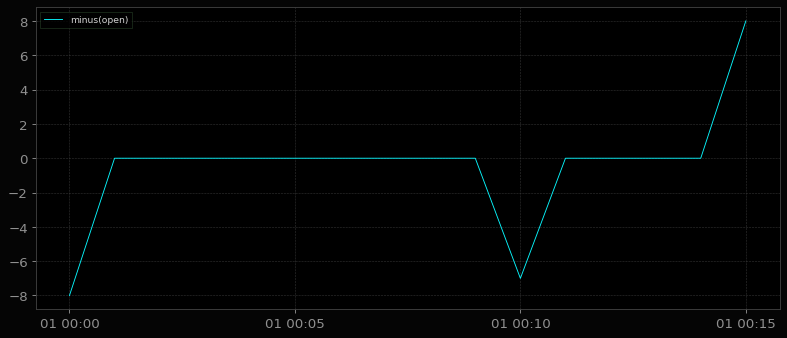

In [49]:
(ohlc.close - ohlc.open).plot()

In [50]:
print(str(ohlc), str(s1))

Test1[1Min] | 15 records
  2024-01-01T00:15:00.000000000 {o:4.000000 | h:12.000000 | l:4.000000 | c:12.000000 | v:2.000000}
  2024-01-01T00:14:00.000000000 {o:17.000000 | h:17.000000 | l:17.000000 | c:17.000000 | v:1.000000}
  2024-01-01T00:13:00.000000000 {o:15.000000 | h:15.000000 | l:15.000000 | c:15.000000 | v:1.000000}
   .......... 
  2024-01-01T00:02:00.000000000 {o:3.000000 | h:3.000000 | l:3.000000 | c:3.000000 | v:1.000000}
  2024-01-01T00:01:00.000000000 {o:2.000000 | h:3.000000 | l:2.000000 | c:2.000000 | v:3.000000}
  2024-01-01T00:00:00.000000000 {o:9.000000 | h:9.000000 | l:1.000000 | c:1.000000 | v:2.000000}
 sma(10)[1Min] | 15 records
  2024-01-01T00:15:00.000000000 10.6
  2024-01-01T00:14:00.000000000 9.9
  2024-01-01T00:13:00.000000000 8.6
   .......... 
  2024-01-01T00:02:00.000000000 nan
  2024-01-01T00:01:00.000000000 nan
  2024-01-01T00:00:00.000000000 nan



In [51]:
s1.to_series()

2024-01-01 00:00:00     NaN
2024-01-01 00:01:00     NaN
2024-01-01 00:02:00     NaN
2024-01-01 00:03:00     NaN
2024-01-01 00:04:00     NaN
2024-01-01 00:05:00     NaN
2024-01-01 00:07:00     NaN
2024-01-01 00:08:00     NaN
2024-01-01 00:09:00     NaN
2024-01-01 00:10:00     NaN
2024-01-01 00:11:00     6.2
2024-01-01 00:12:00     7.4
2024-01-01 00:13:00     8.6
2024-01-01 00:14:00     9.9
2024-01-01 00:15:00    10.6
Name: sma(10), dtype: float64

In [91]:
sma(ohlc.close, 10).to_series()

2024-01-01 00:00:00     NaN
2024-01-01 00:01:00     NaN
2024-01-01 00:02:00     NaN
2024-01-01 00:03:00     NaN
2024-01-01 00:04:00     NaN
2024-01-01 00:05:00     NaN
2024-01-01 00:07:00     NaN
2024-01-01 00:08:00     NaN
2024-01-01 00:09:00     NaN
2024-01-01 00:10:00     NaN
2024-01-01 00:11:00     6.2
2024-01-01 00:12:00     7.4
2024-01-01 00:13:00     8.6
2024-01-01 00:14:00     9.9
2024-01-01 00:15:00    10.6
Name: sma(10), dtype: float64

In [52]:
sma(ohlc.close, 8).to_series()

2024-01-01 00:00:00       NaN
2024-01-01 00:01:00       NaN
2024-01-01 00:02:00       NaN
2024-01-01 00:03:00       NaN
2024-01-01 00:04:00       NaN
2024-01-01 00:05:00       NaN
2024-01-01 00:07:00       NaN
2024-01-01 00:08:00     4.625
2024-01-01 00:09:00     5.500
2024-01-01 00:10:00     5.875
2024-01-01 00:11:00     7.125
2024-01-01 00:12:00     8.375
2024-01-01 00:13:00     9.625
2024-01-01 00:14:00    11.000
2024-01-01 00:15:00    11.500
Name: sma(8), dtype: float64

## How to work with indicators in strategy

In [54]:
xs = TimeSeries('close', '1h')
# compare(xs.shift(1), xs)
hh = highest(xs, 13)
ll = lowest(xs, 13)
test.push(xs, data)

2024-01-01 00:00:00    1015.790426
2024-01-01 01:00:00    1013.933105
2024-01-01 02:00:00    1010.042743
2024-01-01 03:00:00     993.904935
2024-01-01 04:00:00     992.345714
                          ...     
2024-03-10 06:00:00    1121.355038
2024-03-10 07:00:00    1126.807260
2024-03-10 08:00:00    1126.549875
2024-03-10 09:00:00    1127.651104
2024-03-10 10:00:00    1133.487806
Name: close, Length: 1667, dtype: float64

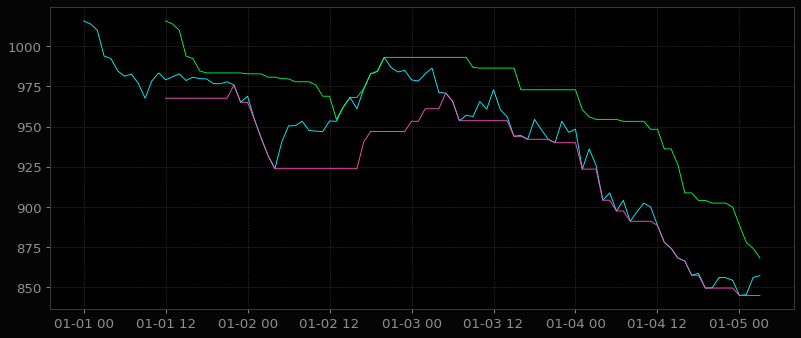

In [56]:
plt.plot(xs.pd()[:100])
plt.plot(highest(xs, 13).pd()[:100])
plt.plot(lowest(xs, 13).pd()[:100])
# plt.plot(hh.pd()[:100])
# plt.plot(xs.pd().rolling(13).max()[:100])

In [57]:
all(abs(highest(xs, 13).pd().dropna() - xs.pd().rolling(13).max().dropna()) <= 1e-4)

True

In [58]:
test.scols(xs.to_series(), xs.shift(1).to_series(), compare(xs, xs.shift(1)).to_series())

,close,lag(1),compare(lag(1))
2024-01-01 00:00:00,1015.790426,NaN,NaN
2024-01-01 01:00:00,1013.933105,1015.790426,-1.0
2024-01-01 02:00:00,1010.042743,1013.933105,-1.0
2024-01-01 03:00:00,993.904935,1010.042743,-1.0
2024-01-01 04:00:00,992.345714,993.904935,-1.0
...,...,...,...
2024-03-10 06:00:00,1121.355038,1116.501212,1.0
2024-03-10 07:00:00,1126.807260,1121.355038,1.0
2024-03-10 08:00:00,1126.549875,1126.807260,-1.0
2024-03-10 09:00:00,1127.651104,1126.549875,1.0


In [59]:
xs.update(recognize_time('2024-03-10 15:00:01'), 1000)
test.scols(xs.pd(), xs.shift(1).pd(), compare(xs, xs.shift(1)).pd())

,close,lag(1),compare(lag(1))
2024-01-01 00:00:00,1015.790426,NaN,NaN
2024-01-01 01:00:00,1013.933105,1015.790426,-1.0
2024-01-01 02:00:00,1010.042743,1013.933105,-1.0
2024-01-01 03:00:00,993.904935,1010.042743,-1.0
2024-01-01 04:00:00,992.345714,993.904935,-1.0
...,...,...,...
2024-03-10 07:00:00,1126.807260,1121.355038,1.0
2024-03-10 08:00:00,1126.549875,1126.807260,-1.0
2024-03-10 09:00:00,1127.651104,1126.549875,1.0
2024-03-10 10:00:00,1133.487806,1127.651104,1.0


Indicators are cached so we can just use them as straight calls

In [60]:
for i in range(len(xs) - 1):
    if (ema(xs, 15)[i] > ema(xs, 50)[i]) and (ema(xs, 15)[i+1] < ema(xs, 50)[i+1]):
        print(pd.Timestamp(xs.times[i]))

2024-03-05 06:00:00
2024-03-01 05:00:00
2024-02-17 22:00:00
2024-02-14 05:00:00
2024-02-10 06:00:00
2024-02-09 04:00:00
2024-02-07 18:00:00
2024-02-01 05:00:00
2024-01-30 06:00:00
2024-01-23 03:00:00
2024-01-20 13:00:00
2024-01-16 00:00:00
2024-01-15 04:00:00
2024-01-13 03:00:00
2024-01-10 21:00:00
2024-01-08 09:00:00
2024-01-06 07:00:00


In [61]:
xs.get_indicators()

{'highest(13)': 2024-01-01 00:00:00            NaN
 2024-01-01 01:00:00            NaN
 2024-01-01 02:00:00            NaN
 2024-01-01 03:00:00            NaN
 2024-01-01 04:00:00            NaN
                           ...     
 2024-03-10 07:00:00    1146.886719
 2024-03-10 08:00:00    1145.627686
 2024-03-10 09:00:00    1145.627686
 2024-03-10 10:00:00    1145.627686
 2024-03-10 15:00:00    1145.627686
 Name: highest(13), Length: 1668, dtype: float64,
 'lowest(13)': 2024-01-01 00:00:00            NaN
 2024-01-01 01:00:00            NaN
 2024-01-01 02:00:00            NaN
 2024-01-01 03:00:00            NaN
 2024-01-01 04:00:00            NaN
                           ...     
 2024-03-10 07:00:00    1116.501221
 2024-03-10 08:00:00    1116.501221
 2024-03-10 09:00:00    1116.501221
 2024-03-10 10:00:00    1116.501221
 2024-03-10 15:00:00    1000.000000
 Name: lowest(13), Length: 1668, dtype: float64,
 'lag(1)': 2024-01-01 00:00:00            NaN
 2024-01-01 01:00:00    1015.79042

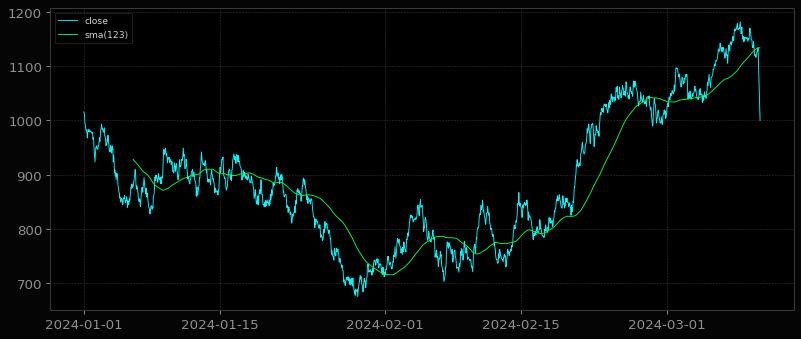

In [62]:
xs.plot()
sma(xs, 123).plot()